In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
import warnings
import logging

# Vô hiệu hóa cảnh báo
warnings.filterwarnings("ignore")

# Thiết lập logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

def forecast_stock_prices(data, split_ratio, time_step=100):
    # Tiền xử lý dữ liệu
    data['Price'] = data['Price'].str.replace(',', '').astype(float)
    df1 = data.reset_index()['Price']

    # Chuẩn hóa dữ liệu
    scaler = MinMaxScaler(feature_range=(0, 1))
    df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

    # Chia train test
    train_size = int(len(df1) * split_ratio)
    test_size = len(df1) - train_size
    train_data, test_data = df1[0:train_size, :], df1[train_size:len(df1), :]

    # Hàm tạo dataset
    def create_dataset(dataset, time_step=1):
        dataX, dataY = [], []
        for i in range(len(dataset) - time_step - 1):
            a = dataset[i:(i + time_step), 0]
            dataX.append(a)
            dataY.append(dataset[i + time_step, 0])
        return np.array(dataX), np.array(dataY)

    # Tạo dữ liệu huấn luyện và kiểm tra
    X_train, y_train = create_dataset(train_data, time_step)
    X_test, y_test = create_dataset(test_data, time_step)

    # Reshape input to be [samples, time steps, features]
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # Define RNN Model
    model = Sequential()
    model.add(SimpleRNN(50, input_shape=(time_step, 1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Train the model
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

    # Dự báo dữ liệu test
    test_predict = model.predict(X_test)

    # Chuẩn hóa ngược dữ liệu dự báo và dữ liệu thực tế
    test_predict = scaler.inverse_transform(test_predict)
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Đánh giá độ chính xác
    rmse = np.sqrt(mean_squared_error(y_test, test_predict))
    mae = mean_absolute_error(y_test, test_predict)
    mape = np.mean(np.abs((y_test - test_predict) / y_test)) * 100



    # Khởi tạo hàm dự đoán
    def predict_future_days(days, model, data, input_size, scaler):
        future_predictions = []
        current_data = data.copy()
        for _ in range(days):
            x_input = current_data[-input_size:].reshape(1, -1)
            x_input = x_input.reshape((1, input_size, 1))
            yhat = model.predict(x_input, verbose=0)
            future_predictions.append(yhat[0][0])
            current_data = np.append(current_data, yhat[0][0])
        return scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

    # Dự báo tương lai
    predict_30days = predict_future_days(30, model, df1, time_step, scaler)
    predict_60days = predict_future_days(60, model, df1, time_step, scaler)
    predict_90days = predict_future_days(90, model, df1, time_step, scaler)

    # Chuẩn hóa ngược dữ liệu huấn luyện và kiểm tra
    train_data = scaler.inverse_transform(train_data)
    test_data = scaler.inverse_transform(test_data)

    # Vẽ biểu đồ
    plt.figure(figsize=(12, 6))

    # Vẽ dữ liệu huấn luyện
    plt.plot(pd.RangeIndex(start=0, stop=train_size, step=1), train_data, label='Train')

    # Vẽ dữ liệu kiểm tra
    plt.plot(pd.RangeIndex(start=train_size, stop=train_size + test_size, step=1), test_data, label='Test')

    # Vẽ dự báo trên tập kiểm tra
    plt.plot(pd.RangeIndex(start=train_size + time_step + 1, stop=train_size + time_step + 1 + len(test_predict), step=1), test_predict, label='Predict')

    # Vẽ dự báo 90 ngày tiếp theo
    future_dates_90 = pd.RangeIndex(start=len(df1), stop=len(df1) + 90, step=1)
    plt.plot(future_dates_90, predict_90days, label='Predict 90 Days', color='purple')

    # Vẽ dự báo 60 ngày tiếp theo
    future_dates_60 = pd.RangeIndex(start=len(df1), stop=len(df1) + 60, step=1)
    plt.plot(future_dates_60, predict_60days, label='Predict 60 Days', color='brown')

    # Vẽ dự báo 30 ngày tiếp theo
    future_dates_30 = pd.RangeIndex(start=len(df1), stop=len(df1) + 30, step=1)
    plt.plot(future_dates_30, predict_30days, label='Predict 30 Days', color='red')

    plt.legend()
    plt.title('Future Price Prediction')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid()
    plt.show()

    print(f'Test RMSE: {rmse}')
    print(f'Test MAE: {mae}')
    print(f'Test MAPE: {mape}')


VIB

Epoch 1/100
11/11 [==============================] - 2s 44ms/step - loss: 0.1855 - val_loss: 0.0856
Epoch 2/100
11/11 [==============================] - 0s 23ms/step - loss: 0.0134 - val_loss: 0.0268
Epoch 3/100
11/11 [==============================] - 0s 21ms/step - loss: 0.0097 - val_loss: 0.0522
Epoch 4/100
11/11 [==============================] - 0s 23ms/step - loss: 0.0040 - val_loss: 0.0117
Epoch 5/100
11/11 [==============================] - 0s 22ms/step - loss: 0.0030 - val_loss: 0.0036
Epoch 6/100
11/11 [==============================] - 0s 26ms/step - loss: 0.0027 - val_loss: 0.0033
Epoch 7/100
11/11 [==============================] - 0s 22ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 8/100
11/11 [==============================] - 0s 22ms/step - loss: 0.0022 - val_loss: 0.0016
Epoch 9/100
11/11 [==============================] - 0s 22ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 10/100
11/11 [==============================] - 0s 25ms/step - loss: 0.0019 - val_loss: 0.0014

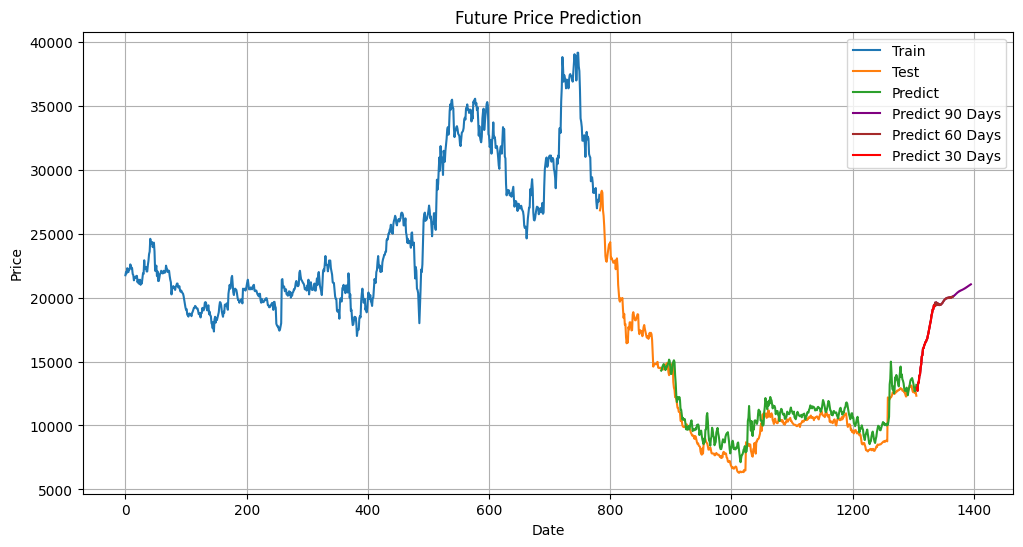

Test RMSE: 1047.4964443657361
Test MAE: 892.7323015402843
Test MAPE: 9.921382237692795


In [14]:
df = pd.read_csv('/content/VIB-Historical-Data.csv')
forecast_stock_prices(df, split_ratio=0.6)

BID

Epoch 1/100
11/11 [==============================] - 2s 72ms/step - loss: 0.0038 - val_loss: 0.0016
Epoch 2/100
11/11 [==============================] - 0s 40ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 3/100
11/11 [==============================] - 1s 49ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 4/100
11/11 [==============================] - 1s 52ms/step - loss: 9.9492e-04 - val_loss: 8.4325e-04
Epoch 5/100
11/11 [==============================] - 1s 46ms/step - loss: 9.6046e-04 - val_loss: 7.7697e-04
Epoch 6/100
11/11 [==============================] - 1s 56ms/step - loss: 8.7077e-04 - val_loss: 9.4621e-04
Epoch 7/100
11/11 [==============================] - 0s 26ms/step - loss: 8.4996e-04 - val_loss: 8.4816e-04
Epoch 8/100
11/11 [==============================] - 0s 22ms/step - loss: 8.0113e-04 - val_loss: 7.0259e-04
Epoch 9/100
11/11 [==============================] - 0s 26ms/step - loss: 7.6898e-04 - val_loss: 6.4542e-04
Epoch 10/100
11/11 [==============================] 

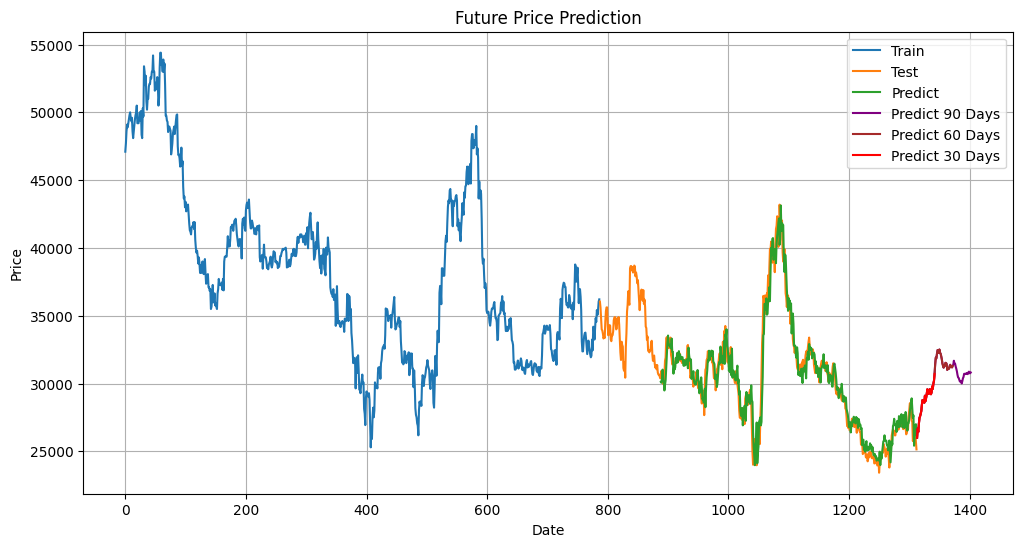

Test RMSE: 755.1590848695223
Test MAE: 556.0915321691177
Test MAPE: 1.8432499419575827


In [15]:

df = pd.read_csv('/content/BID-Historical-Data.csv')
forecast_stock_prices(df, split_ratio=0.6)

STB

Epoch 1/100
11/11 [==============================] - 2s 48ms/step - loss: 0.1066 - val_loss: 0.1130
Epoch 2/100
11/11 [==============================] - 0s 26ms/step - loss: 0.0152 - val_loss: 0.0672
Epoch 3/100
11/11 [==============================] - 0s 25ms/step - loss: 0.0070 - val_loss: 0.0077
Epoch 4/100
11/11 [==============================] - 0s 26ms/step - loss: 0.0045 - val_loss: 0.0024
Epoch 5/100
11/11 [==============================] - 0s 23ms/step - loss: 0.0033 - val_loss: 0.0061
Epoch 6/100
11/11 [==============================] - 0s 25ms/step - loss: 0.0026 - val_loss: 0.0135
Epoch 7/100
11/11 [==============================] - 0s 28ms/step - loss: 0.0023 - val_loss: 0.0152
Epoch 8/100
11/11 [==============================] - 0s 24ms/step - loss: 0.0022 - val_loss: 0.0127
Epoch 9/100
11/11 [==============================] - 0s 25ms/step - loss: 0.0021 - val_loss: 0.0085
Epoch 10/100
11/11 [==============================] - 0s 25ms/step - loss: 0.0020 - val_loss: 0.0076

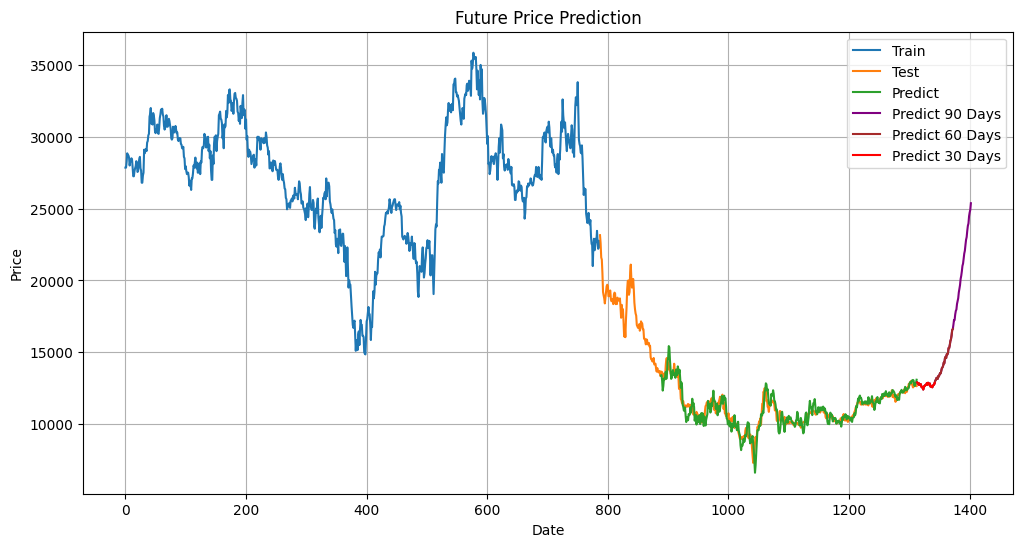

Test RMSE: 437.291932478311
Test MAE: 326.3718313419118
Test MAPE: 3.000203981477866


In [16]:
df = pd.read_csv('/content/STB-Historical-Data.csv')
forecast_stock_prices(df, split_ratio=0.6)